# 酒店选址与客流预测基础模型

本笔记本演示酒店选址和客流预测的基础模型实现。

## 1. 导入必要的库

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import sys
import os

# 添加项目根目录到路径
sys.path.append('..')

# 导入自定义模块
from src.models.spatial_temporal_model import SpatialTemporalModel, SpatialTemporalTrainer, SpatialTemporalDataset, prepare_sequence_data
from src.models.location_selection_model import LocationSelectionModel
from src.utils.data_collection import download_hotel_booking_data, fetch_poi_data
from src.utils.data_preprocessing import preprocess_hotel_data, create_features, integrate_poi_data

# 设置绘图样式
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)

## 2. 数据加载与预处理

In [19]:
# 加载原始数据（可选）
try:
    hotel_df = pd.read_csv('../data/raw/hotel-booking-demand/hotel_bookings.csv')
    print(f"原始数据加载成功！形状: {hotel_df.shape}")
except FileNotFoundError:
    print("原始数据文件不存在，请先下载数据")
    hotel_df = pd.DataFrame()  # 创建空DataFrame

原始数据加载成功！形状: (5000, 35)


In [20]:
# 直接加载预处理后的数据
try:
    processed_df = pd.read_csv('../data/processed/hotel_processed.csv')
    print(f"预处理数据加载成功！形状: {processed_df.shape}")
    processed_df.head()
except FileNotFoundError:
    print("预处理数据文件不存在，请先运行fix_preprocessing.py脚本")

预处理数据加载成功！形状: (5000, 43)


In [21]:
# 加载特征工程后的数据
try:
    features_df = pd.read_csv('../data/processed/hotel_features.csv')
    print(f"特征数据加载成功！形状: {features_df.shape}")
    features_df.head()
except FileNotFoundError:
    print("特征数据文件不存在，请先运行fix_preprocessing.py脚本")
    # 如果预处理数据存在但特征数据不存在，可以创建特征
    if 'processed_df' in locals() and not processed_df.empty:
        print("从预处理数据创建特征...")
        features_df = create_features(processed_df)
        # 保存处理后的数据
        os.makedirs('../data/processed', exist_ok=True)
        features_df.to_csv('../data/processed/hotel_features.csv', index=False)
        print("特征数据已保存到 ../data/processed/hotel_features.csv")

特征数据加载成功！形状: (5000, 63)


## 3. 空间时间序列模型

In [22]:
# 准备时间序列数据
if 'features_df' in locals() and not features_df.empty:
    # 选择特征列和目标列
    # 注意: 实际列名应根据实际数据调整
    feature_cols = ['lead_time', 'arrival_date_month_num', 'stays_in_weekend_nights', 
                     'stays_in_week_nights', 'adults', 'children', 'is_repeated_guest', 
                     'previous_cancellations', 'previous_bookings_not_canceled', 
                     'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests']
    
    # 确保所有特征列都存在
    for col in feature_cols:
        if col not in features_df.columns:
            print(f"警告：列 {col} 不在特征数据中")
    
    # 只使用存在的特征列
    available_feature_cols = [col for col in feature_cols if col in features_df.columns]
    
    target_cols = ['adr']  # 平均每日房价
    
    # 准备序列数据
    X, y, _ = prepare_sequence_data(features_df, available_feature_cols, target_cols, seq_len=7, stride=1)
    
    print(f"序列数据形状: X={X.shape}, y={y.shape}")
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"训练集: X={X_train.shape}, y={y_train.shape}")
    print(f"测试集: X={X_test.shape}, y={y_test.shape}")

序列数据形状: X=(4994, 7, 12), y=(4994, 1)
训练集: X=(3995, 7, 12), y=(3995, 1)
测试集: X=(999, 7, 12), y=(999, 1)


In [23]:
# 创建数据集和数据加载器
if 'X_train' in locals():
    batch_size = 32
    
    train_dataset = SpatialTemporalDataset(X_train, y_train)
    test_dataset = SpatialTemporalDataset(X_test, y_test)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"训练数据批次数: {len(train_loader)}")
    print(f"测试数据批次数: {len(test_loader)}")

训练数据批次数: 125
测试数据批次数: 32


In [24]:
# 创建并训练模型
if 'train_loader' in locals():
    # 模型参数
    input_dim = X_train.shape[2]  # 特征维度
    hidden_dim = 64
    output_dim = y_train.shape[1]  # 目标维度
    num_nodes = 100  # 空间节点数量
    seq_len = X_train.shape[1]  # 序列长度
    
    # 创建模型
    model = SpatialTemporalModel(
        input_dim=input_dim, 
        hidden_dim=hidden_dim, 
        output_dim=output_dim, 
        num_nodes=num_nodes, 
        seq_len=seq_len
    )
    
    # 创建训练器
    trainer = SpatialTemporalTrainer(model, learning_rate=0.001)
    
    # 训练模型
    print("开始训练空间时间模型...")
    # 注意: 实际训练时应使用更多的epoch
    history = trainer.train(train_loader, test_loader, epochs=5, patience=3)

2025-04-19 21:39:46,093 - src.models.spatial_temporal_model - INFO - 模型初始化完成，使用设备: cpu
2025-04-19 21:39:46,094 - src.models.spatial_temporal_model - INFO - 开始训练，总epochs: 5


开始训练空间时间模型...


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

In [25]:
# 可视化训练历史
if 'history' in locals():
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_losses'], label='训练损失')
    plt.plot(history['valid_losses'], label='验证损失')
    plt.title('训练过程中的损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    metrics = [m['rmse'] for m in history['valid_metrics']]
    plt.plot(metrics, label='验证RMSE')
    plt.title('验证集RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## 4. 选址评分模型

In [26]:
# 创建位置特征数据集
# 注意: 实际应用中需要真实的位置数据
# 这里仅为演示，创建一些假数据

def create_dummy_location_data(n_locations=50):
    """创建模拟位置数据"""
    np.random.seed(42)
    
    location_data = {
        'location_id': [f'LOC_{i:03d}' for i in range(n_locations)],
        'latitude': np.random.uniform(31.1, 31.3, n_locations),
        'longitude': np.random.uniform(121.4, 121.6, n_locations),
        'poi_restaurant_count': np.random.randint(5, 50, n_locations),
        'poi_shopping_count': np.random.randint(3, 30, n_locations),
        'poi_entertainment_count': np.random.randint(2, 20, n_locations),
        'poi_transport_count': np.random.randint(1, 15, n_locations),
        'distance_to_city_center': np.random.uniform(0.5, 15.0, n_locations),
        'distance_to_airport': np.random.uniform(5.0, 50.0, n_locations),
        'distance_to_subway': np.random.uniform(0.1, 3.0, n_locations),
        'population_density': np.random.uniform(5000, 25000, n_locations),
        'income_per_capita': np.random.uniform(80000, 150000, n_locations),
        'unemployment_rate': np.random.uniform(2.0, 8.0, n_locations),
        'competitor_count': np.random.randint(0, 10, n_locations),
        'area_km2': np.random.uniform(0.5, 5.0, n_locations)
    }
    
    # 添加一个模拟目标值(可以视为历史业绩)
    # 假设业绩与多个因素有关，并添加一些随机噪声
    score = (
        0.3 * location_data['poi_restaurant_count'] + 
        0.2 * location_data['poi_shopping_count'] + 
        0.2 * location_data['poi_entertainment_count'] + 
        0.3 * location_data['poi_transport_count'] - 
        0.5 * location_data['distance_to_city_center'] - 
        0.2 * location_data['distance_to_subway'] + 
        0.1 * location_data['population_density'] / 1000 + 
        0.1 * location_data['income_per_capita'] / 10000 - 
        0.3 * location_data['competitor_count'] + 
        np.random.normal(0, 5, n_locations)
    )
    # 转换为正值并归一化到0-100范围
    score = score - min(score)
    score = 100 * score / max(score)
    location_data['historical_score'] = score
    
    return pd.DataFrame(location_data)

# 创建位置数据
location_df = create_dummy_location_data(100)
print(f"生成模拟位置数据: {location_df.shape}")
location_df.head()

生成模拟位置数据: (100, 16)


,location_id,latitude,longitude,poi_restaurant_count,poi_shopping_count,poi_entertainment_count,poi_transport_count,distance_to_city_center,distance_to_airport,distance_to_subway,population_density,income_per_capita,unemployment_rate,competitor_count,area_km2,historical_score
0,LOC_000,31.174908,121.406286,28,22,17,10,4.573966,10.799587,0.911939,13017.028335,96672.794673,4.608964,8,3.002818,40.435466
1,LOC_001,31.290143,121.527282,15,3,8,10,14.280967,10.762063,2.331530,14240.116073,86960.897493,3.478412,6,3.904861,37.426320
2,LOC_002,31.246399,121.462871,12,10,5,12,13.408825,11.835621,0.642427,23945.666792,97022.053370,6.914614,3,1.664097,40.420128
3,LOC_003,31.219732,121.501714,40,16,2,1,7.107023,11.247223,1.038670,8067.028062,130558.685230,6.796495,3,1.369098,52.996921
4,LOC_004,31.131204,121.581513,42,18,6,13,9.491923,33.839364,1.333766,16724.596640,139898.752767,6.168179,7,0.878442,64.945835


In [27]:
# 准备选址模型数据
feature_cols = [
    'poi_restaurant_count', 'poi_shopping_count', 'poi_entertainment_count', 'poi_transport_count',
    'distance_to_city_center', 'distance_to_airport', 'distance_to_subway',
    'population_density', 'income_per_capita', 'unemployment_rate', 'competitor_count', 'area_km2'
]

X = location_df[feature_cols].values
y = location_df['historical_score'].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"训练集: X={X_train.shape}, y={y_train.shape}")
print(f"测试集: X={X_test.shape}, y={y_test.shape}")

训练集: X=(80, 12), y=(80,)
测试集: X=(20, 12), y=(20,)


In [28]:
# 训练选址评分模型
print("开始训练选址评分模型...")

# 使用XGBoost模型
location_model = LocationSelectionModel(model_type='xgboost')
location_model.fit(X_train, y_train, feature_names=feature_cols)

# 在测试集上评估
y_pred = location_model.predict(X_test)

# 计算指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"选址模型评估指标:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

2025-04-19 21:40:06,729 - src.models.location_selection_model - INFO - 初始化xgboost选址模型
2025-04-19 21:40:06,729 - src.models.location_selection_model - INFO - 开始训练xgboost选址模型，特征数量: 12
--- Logging error ---
Traceback (most recent call last):
  File "c:\Python313\Lib\logging\__init__.py", line 1153, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'gbk' codec can't encode character '\xb2' in position 122: illegal multibyte sequence
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Python313\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Python313\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Python313\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Python313\Lib\site-packages\tornado\plat

开始训练选址评分模型...
选址模型评估指标:
MSE:  310.5204
RMSE: 17.6216
MAE:  14.5749
R²:   -0.0312


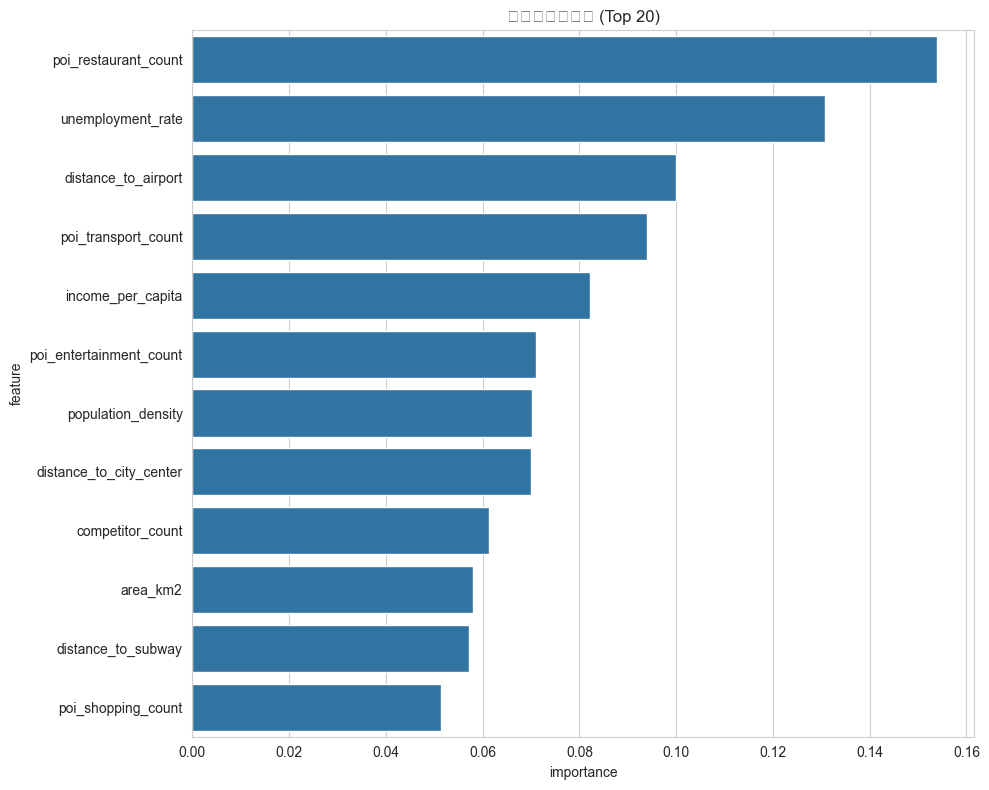

,feature,importance
0,poi_restaurant_count,0.153932
9,unemployment_rate,0.130797
5,distance_to_airport,0.099876
3,poi_transport_count,0.093906
8,income_per_capita,0.082262
2,poi_entertainment_count,0.070978
7,population_density,0.070103
4,distance_to_city_center,0.070048
10,competitor_count,0.061394
11,area_km2,0.058045


In [29]:
# 查看特征重要性
feature_importance = location_model.get_feature_importance(plot=True)
feature_importance

In [30]:
# 为候选位置评分（使用测试集作为候选位置）
test_df = location_df.iloc[list(np.random.choice(len(location_df), 20, replace=False))].copy()
scored_locations = location_model.score_locations(test_df, feature_cols)

print("候选位置评分结果:")
scored_locations[['location_id', 'predicted_score'] + feature_cols].head(10)

候选位置评分结果:


,location_id,predicted_score,poi_restaurant_count,poi_shopping_count,poi_entertainment_count,poi_transport_count,distance_to_city_center,distance_to_airport,distance_to_subway,population_density,income_per_capita,unemployment_rate,competitor_count,area_km2
65,LOC_065,84.915634,36,28,14,1,8.502649,31.407850,1.920353,9198.111862,92275.989504,7.634406,4,3.759902
40,LOC_040,80.972359,38,17,9,10,4.464403,38.636192,2.406275,11939.064038,117914.395026,7.067296,8,1.636289
17,LOC_017,68.924316,45,24,18,13,10.428602,10.428614,0.283787,13482.613426,109499.718541,6.839367,7,1.307738
35,LOC_035,68.525528,42,9,15,13,14.563759,21.671245,0.292839,11669.983434,142618.655883,7.546377,2,2.226255
58,LOC_058,62.789669,41,23,5,1,5.693359,45.073728,2.708766,13292.482475,80769.708006,5.695179,5,4.592860
29,LOC_029,61.231369,37,3,9,13,5.958719,7.748508,2.508796,16825.508715,100612.603168,3.083452,9,4.335866
3,LOC_003,53.007633,40,16,2,1,7.107023,11.247223,1.038670,8067.028062,130558.685230,6.796495,3,1.369098
18,LOC_018,51.964756,40,28,13,5,2.857946,25.735045,2.970885,19728.884712,142487.019775,5.952700,5,3.891645
45,LOC_045,47.449192,37,18,5,3,14.951234,28.025485,2.029072,7817.140408,148908.152649,3.380053,7,0.959871
16,LOC_016,46.308418,20,28,3,5,12.300028,8.991614,0.489803,17134.300928,120812.909268,6.393349,2,2.264680


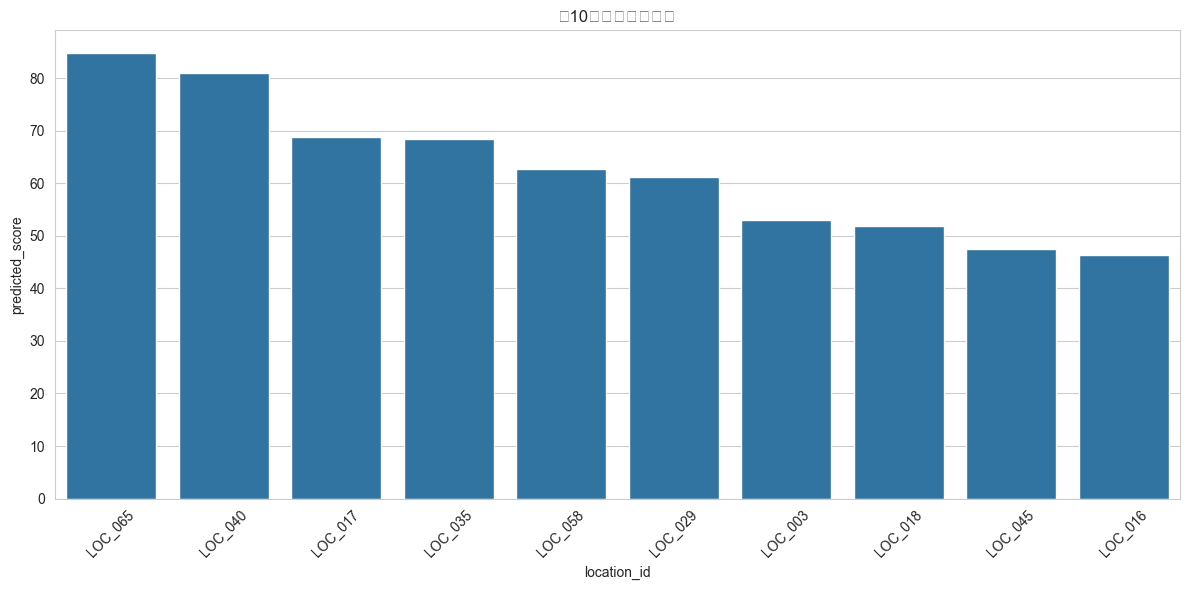

In [31]:
# 可视化候选位置得分
plt.figure(figsize=(12, 6))
sns.barplot(x='location_id', y='predicted_score', data=scored_locations.head(10))
plt.title('前10个候选位置得分')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. 保存模型

In [ ]:
# 创建模型目录
os.makedirs('../data/models', exist_ok=True)

# 保存选址模型
if 'location_model' in locals():
    location_model.save_model('../data/models/location_model.pkl')
    print("选址模型已保存到 ../data/models/location_model.pkl")

# 保存空间时间模型
if 'trainer' in locals() and 'model' in locals():
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': input_dim,
        'hidden_dim': hidden_dim,
        'output_dim': output_dim,
        'num_nodes': num_nodes,
        'seq_len': seq_len
    }, '../data/models/spatial_temporal_model.pt')
    print("空间时间模型已保存到 ../data/models/spatial_temporal_model.pt")

## 6. 总结

在本笔记本中，我们实现了酒店选址与客流预测的两个基础模型：

1. **空间时间注意力机制模型**：用于预测酒店入住率和每日平均房价，结合了空间和时间两个维度的信息。
2. **选址评分模型**：使用XGBoost算法，基于位置特征为候选地址打分，帮助酒店选择最佳位置。

这些模型可以进一步优化和扩展：

- 收集更多真实数据，特别是位置相关的POI数据和历史入住率数据
- 优化模型超参数
- 增加更多特征，如季节性特征、天气数据、事件数据等
- 实现冷启动策略，处理新酒店没有历史数据的情况
- 部署模型并提供API服务